In [1]:
import pandas as pd
import numpy as np
import pyAgrum as gum
import tempfile
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [27]:
# Load the historical data
data = pd.read_csv("data/INVEST_clean.csv", parse_dates=["Date"])

# Step 1: Filter the data for General Industrials and Consumer Services sectors (2015-2018)
general_industrials_companies = [
    "SUPER GROUP", "PPC", "NAMPAK", "MURRAY & ROBERTS", "KAP INDUSTRIAL",
    "INVICTA", "IMPERIAL", "BIDVEST GROUP", "BARLOWORLD", "AFRIMAT"
]
consumer_services_companies = [
    "WOOLWORTHS HDG", "TSOGO SUN", "TRUWORTHS INTL"
]

filtered_data = data[
    (data['Date'].dt.year >= 2015) & 
    (data['Date'].dt.year <= 2018) & 
    (data['Name'].isin(general_industrials_companies + consumer_services_companies))
].copy()

In [28]:
# Step 2: Create columns needed for the Bayesian Network
filtered_data['MarketCondition'] = np.where(filtered_data['Price'] > filtered_data['Price'].mean(), 'Good', 'Bad')
filtered_data['SectorPerformance'] = np.where(filtered_data['PE'] > filtered_data['PE'].median(), 'Positive', 'Negative')

def get_share_performance(price):
    if price > filtered_data['Price'].quantile(0.75):
        return 'High'
    elif price > filtered_data['Price'].quantile(0.25):
        return 'Medium'
    else:
        return 'Low'

filtered_data['SharePerformance'] = filtered_data['Price'].apply(get_share_performance)

In [29]:
# Step 3: Encode categorical variables
le_market = LabelEncoder()
le_sector = LabelEncoder()
le_share = LabelEncoder()
filtered_data['MarketCondition'] = le_market.fit_transform(filtered_data['MarketCondition'])
filtered_data['SectorPerformance'] = le_sector.fit_transform(filtered_data['SectorPerformance'])
filtered_data['SharePerformance'] = le_share.fit_transform(filtered_data['SharePerformance'])

In [30]:
# Step 4: Define the Bayesian Network structure
bn_learn = gum.BayesNet("INVEST_BDN_Learning")
bn_learn.add(gum.LabelizedVariable("MarketCondition", "General Market Condition", 2))  
bn_learn.add(gum.LabelizedVariable("SectorPerformance", "Sector-specific performance", 2))  
bn_learn.add(gum.LabelizedVariable("SharePerformance", "Individual Share Performance", 3))  
bn_learn.addArc("MarketCondition", "SectorPerformance")
bn_learn.addArc("SectorPerformance", "SharePerformance")

In [31]:
# Step 5: Implement Learning Algorithms and Walk-Forward Validation
def calculate_performance_metrics(returns, risk_free_rate=0.02):
    cumulative_return = (1 + returns).prod() - 1
    average_annual_return = returns.mean() * 252
    total_return = returns.sum()
    excess_returns = returns - risk_free_rate / 252
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    return cumulative_return, average_annual_return, total_return, sharpe_ratio

In [39]:
def walk_forward_validation(data, bn, n_splits=3):
    results = []
    learned_models = {'MLE': None, 'BPE': None, 'EM': None}  # Dictionary to hold learned models
    
    # Perform walk-forward splits and accumulate training data
    for i in range(n_splits):
        # Split the data into train and test sets dynamically
        train = data[data['Date'].dt.year < (2015 + i)]
        test = data[data['Date'].dt.year == (2015 + i)]
        
        if len(train) == 0 or len(test) == 0:
            continue

        # Save the train set to temporary CSV files for each learner
        with tempfile.NamedTemporaryFile(mode='w+', suffix=".csv", delete=False) as temp_file_mle, \
             tempfile.NamedTemporaryFile(mode='w+', suffix=".csv", delete=False) as temp_file_bpe, \
             tempfile.NamedTemporaryFile(mode='w+', suffix=".csv", delete=False) as temp_file_em:
            
            train[['MarketCondition', 'SectorPerformance', 'SharePerformance']].to_csv(temp_file_mle.name, index=False)
            train[['MarketCondition', 'SectorPerformance', 'SharePerformance']].to_csv(temp_file_bpe.name, index=False)
            train[['MarketCondition', 'SectorPerformance', 'SharePerformance']].to_csv(temp_file_em.name, index=False)

            # Learn using MLE
            learner_mle = gum.BNLearner(temp_file_mle.name, bn)
            bn_mle = learner_mle.learnParameters(bn.dag())
            learned_models['MLE'] = bn_mle  # Store learned model

            # Learn using BPE (Bayesian Parameter Estimation)
            learner_bpe = gum.BNLearner(temp_file_bpe.name, bn)  
            bn_bpe = learner_bpe.learnParameters(bn.dag())  
            learned_models['BPE'] = bn_bpe  # Store learned model

            # Learn using EM
            learner_em = gum.BNLearner(temp_file_em.name, bn)
            bn_em = learner_em.learnParameters(bn.dag())  
            learned_models['EM'] = bn_em  # Store learned model

        # Evaluate each model on the test set
        for model, label in zip([bn_mle, bn_bpe, bn_em], ['MLE', 'BPE', 'EM']):
            inference = gum.LazyPropagation(model)
            predictions = []
            
            for _, row in test.iterrows():
                inference.setEvidence({
                    "MarketCondition": int(row['MarketCondition']),
                    "SectorPerformance": int(row['SectorPerformance'])
                })
                inference.makeInference()
                predicted_share_performance = np.argmax(inference.posterior("SharePerformance").tolist())
                predictions.append(predicted_share_performance)

            # Calculate accuracy based on predicted values
            accuracy = sum(np.array(predictions) == test['SharePerformance'].values) / len(test)

            # Calculate performance metrics based on actual returns from test set
            test_returns = test['Price'].pct_change().dropna()
            cumulative_return, average_annual_return, total_return, sharpe_ratio = calculate_performance_metrics(test_returns)

            # Append results, including accuracy
            results.append((label, int(2015 + i), accuracy, cumulative_return, average_annual_return, total_return, sharpe_ratio))

    return results, learned_models  # Return both results and learned models

In [40]:
# Execute walk-forward validation and collect results
results, learned_models = walk_forward_validation(filtered_data, bn_learn)
performance_df = pd.DataFrame(results, columns=['Model', 'Year', 'Accuracy', 'Cumulative Return', 'Average Annual Return', 'Total Return', 'Sharpe Ratio'])

# Display results
print(performance_df)

  Model  Year  Accuracy  Cumulative Return  Average Annual Return  \
0   MLE  2016  0.538462           1.042821              18.484876   
1   BPE  2016  0.538462           1.042821              18.484876   
2    EM  2016  0.538462           1.042821              18.484876   
3   MLE  2017  0.506410           1.584679              19.611833   
4   BPE  2017  0.506410           1.584679              19.611833   
5    EM  2017  0.506410           1.584679              19.611833   

   Total Return  Sharpe Ratio  
0     11.369666      2.197300  
1     11.369666      2.197300  
2     11.369666      2.197300  
3     12.062834      1.949748  
4     12.062834      1.949748  
5     12.062834      1.949748  


In [41]:
# Comparative Analysis: Print Accuracy and Sensitivity to Data Changes
for model in performance_df['Model'].unique():
    subset = performance_df[performance_df['Model'] == model]
    avg_cumulative_return = subset['Cumulative Return'].mean()
    avg_sharpe_ratio = subset['Sharpe Ratio'].mean()
    
    print(f"{model} - Average Cumulative Return: {avg_cumulative_return:.2f}, Average Sharpe Ratio: {avg_sharpe_ratio:.2f}")

# Visualize CPTs for SectorPerformance and SharePerformance for each algorithm
def visualize_cpts(bn_model, title):
    print(f"\n{title} Conditional Probability Tables:")
    
    for var in ["SectorPerformance", "SharePerformance"]:
        cpt = bn_model.cpt(var)
        print(f"\nCPT for {var}:")
        print(cpt)

# Visualize CPTs for each model
visualize_cpts(learned_models['MLE'], "MLE")
visualize_cpts(learned_models['BPE'], "BPE")
visualize_cpts(learned_models['EM'], "EM")

MLE - Average Cumulative Return: 1.31, Average Sharpe Ratio: 2.07
BPE - Average Cumulative Return: 1.31, Average Sharpe Ratio: 2.07
EM - Average Cumulative Return: 1.31, Average Sharpe Ratio: 2.07

MLE Conditional Probability Tables:

CPT for SectorPerformance:

      ||  SectorPerformance|
Market||0        |1        |
------||---------|---------|
0     || 0.5851  | 0.4149  |
1     || 0.4758  | 0.5242  |


CPT for SharePerformance:

      ||  SharePerformance           |
Sector||0        |1        |2        |
------||---------|---------|---------|
0     || 0.2071  | 0.2663  | 0.5266  |
1     || 0.3217  | 0.1748  | 0.5035  |


BPE Conditional Probability Tables:

CPT for SectorPerformance:

      ||  SectorPerformance|
Market||0        |1        |
------||---------|---------|
0     || 0.5851  | 0.4149  |
1     || 0.4758  | 0.5242  |


CPT for SharePerformance:

      ||  SharePerformance           |
Sector||0        |1        |2        |
------||---------|---------|---------|
0     || 0

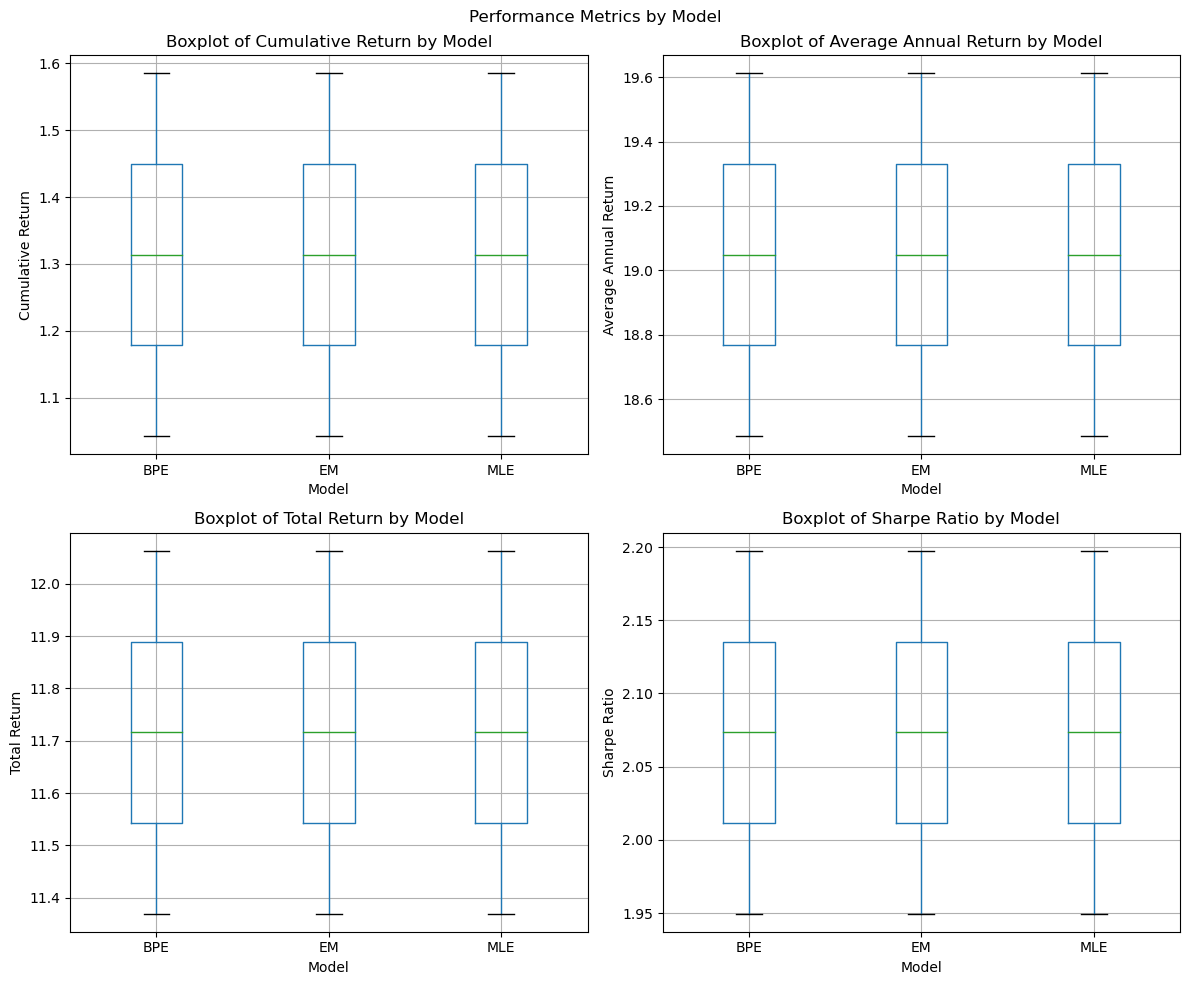

In [35]:
# Plotting boxplots for performance metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a grid of subplots

# Boxplot for Cumulative Return
performance_df.boxplot(column='Cumulative Return', by='Model', ax=axs[0, 0])
axs[0, 0].set_title('Boxplot of Cumulative Return by Model')
axs[0, 0].set_xlabel('Model')
axs[0, 0].set_ylabel('Cumulative Return')

# Boxplot for Average Annual Return
performance_df.boxplot(column='Average Annual Return', by='Model', ax=axs[0, 1])
axs[0, 1].set_title('Boxplot of Average Annual Return by Model')
axs[0, 1].set_xlabel('Model')
axs[0, 1].set_ylabel('Average Annual Return')

# Boxplot for Total Return
performance_df.boxplot(column='Total Return', by='Model', ax=axs[1, 0])
axs[1, 0].set_title('Boxplot of Total Return by Model')
axs[1, 0].set_xlabel('Model')
axs[1, 0].set_ylabel('Total Return')

# Boxplot for Sharpe Ratio
performance_df.boxplot(column='Sharpe Ratio', by='Model', ax=axs[1, 1])
axs[1, 1].set_title('Boxplot of Sharpe Ratio by Model')
axs[1, 1].set_xlabel('Model')
axs[1, 1].set_ylabel('Sharpe Ratio')

# Adjust layout and show plots
plt.suptitle('Performance Metrics by Model')  # Overall title for the figure
plt.tight_layout()
plt.show()